### Importing the Libraries


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error

### Importing the dataset


In [9]:
dataset = pd.read_csv('dataset/dataset.csv', header = None)
dataset.columns = dataset.iloc[0]
dataset = dataset[1:]
dataset = dataset.drop(columns=['Year'])

### Encoding Categorical Data


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['District'] = label_encoder.fit_transform(dataset['District'])

### Handling Missing Values


In [11]:
# dataset = dataset.apply(pd.to_numeric, errors='coerce')
# dataset.fillna(dataset.median(), inplace=True)
# dataset['Total Cases'] = dataset.iloc[:, 37:50].sum(axis=1)
# dataset = dataset.drop(dataset.columns[37:49], axis=1)

### Handling Missing Values : Interpolation

In [12]:
# dataset = dataset.apply(pd.to_numeric, errors='coerce')
# dataset.interpolate(method='linear', inplace=True)
# dataset['Total Cases'] = dataset.iloc[:, 37:50].sum(axis=1)
# dataset = dataset.drop(dataset.columns[37:49], axis=1)

dataset = dataset.apply(pd.to_numeric, errors='coerce')
# dataset.fillna(dataset.median(), inplace=True)
# dataset.fillna(dataset.mode(), inplace=True)
# dataset.interpolate(method='linear', inplace=True)
dataset.ffill(inplace=True)
dataset['Total Cases'] = dataset.iloc[:, 37:50].sum(axis=1)
dataset = dataset.drop(dataset.columns[37:49], axis=1)

### Test/Train Split


In [13]:
from sklearn.model_selection import train_test_split

X = dataset.iloc[:, 0:-1].values
Y = dataset.iloc[:, -1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

### Hyperparameter Tuning

#### Bayesian Optimization

In [14]:
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from skopt.space import Categorical, Integer

# Impute missing values in X_train
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

if np.any(np.isnan(X_train_imputed)) or np.any(np.isinf(X_train_imputed)):
    raise ValueError("Data contains NaN or infinite values after imputation.")

# Define the parameter grid for Bayesian Optimization
param_grid = {
    'criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical([None, 'sqrt', 'log2']),
    'max_leaf_nodes': Integer(10, 100)
}

# Initialize the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    search_spaces=param_grid,
    n_iter=30,  # Use fewer iterations for simplicity
    cv=3,       # 3-fold cross-validation
    random_state=42,
    verbose=0   # No extra output
)

# Perform the search to find the best parameters
bayes_search.fit(X_train_imputed, Y_train)

# Print the best parameters
print("Best parameters found: ", bayes_search.best_params_)


Best parameters found:  OrderedDict({'criterion': 'absolute_error', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': 96, 'min_samples_leaf': 6, 'min_samples_split': 15})


#### Random Search

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from scipy.stats import randint

if np.any(np.isnan(X_train_imputed)) or np.any(np.isinf(X_train_imputed)):
    raise ValueError("Data contains NaN or infinite values after imputation.")

# Define the parameter grid for Randomized Search
param_distributions = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': randint(10, 100)
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=30,       # Number of random parameter combinations to try
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=3,            # 3-fold cross-validation
    random_state=42, # For reproducibility
    verbose=0,       # No extra output
    n_jobs=-1        # Use all available cores for parallel processing
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_imputed, Y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'criterion': 'absolute_error', 'max_depth': 45, 'max_features': None, 'max_leaf_nodes': 82, 'min_samples_leaf': 8, 'min_samples_split': 13}


#### Hyperband


In [16]:
from sklearn.experimental import enable_halving_search_cv  # Needed for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.model_selection import train_test_split

# Assume your data is in X, Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Validate data
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    raise ValueError("X_train contains NaN or infinite values.")
if np.any(Y_train < 0):
    raise ValueError("Y_train contains negative values incompatible with 'poisson' criterion.")

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [10, 20, 50, 100]
}

# Initialize HalvingGridSearchCV with verbose=0
hyperband_search = HalvingGridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    factor=3,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,  # Suppress extra output
    n_jobs=-1,
    min_resources=20,
    random_state=42
)

# Fit the Hyperband search object
hyperband_search.fit(X_train, Y_train)

# Print only the best parameters
print("Best parameters found: ", hyperband_search.best_params_)




Best parameters found:  {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 10}


### Training Model


In [17]:
# Best parameters found:  OrderedDict({'criterion': 'absolute_error', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 8, 'min_samples_split': 7})
# # regressor =  DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 50, max_features = None, max_leaf_nodes = 20, min_samples_leaf = 8, min_samples_split = 7)

# Best parameters found:  {'criterion': 'absolute_error', 'max_depth': 45, 'max_features': None, 'max_leaf_nodes': 82, 'min_samples_leaf': 8, 'min_samples_split': 13}
# regressor =  DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 45, max_features = None, max_leaf_nodes = 82, min_samples_leaf = 8, min_samples_split = 13)

# Best parameters found:  {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
# regressor =  DecisionTreeRegressor(criterion = 'absolute_error', max_depth = 5, max_features = 'log2', max_leaf_nodes = 10, min_samples_leaf = 2, min_samples_split = 10)


regressor = DecisionTreeRegressor()
regressor.fit(X_train, Y_train)


DecisionTreeRegressor()

#### Comparing Values


[[  1448.   1063.]
 [  1448.   2841.]
 [  1281.      0.]
 [     8.     18.]
 [     0.    564.]
 [  1186.   5628.]
 [  1442.    241.]
 [  2240.   3060.]
 [    29.     81.]
 [   111.   4533.]
 [   222.    395.]
 [  5386.   3156.]
 [   122.      8.]
 [    23.    141.]
 [ 17719.   1005.]
 [     0.      0.]
 [    27.      3.]
 [  6092.    493.]
 [   250.      0.]
 [  1442.   2153.]
 [   341.   9399.]
 [  1052.    101.]
 [   527.    335.]
 [   100.    631.]
 [   527.    485.]
 [  2817.   2252.]
 [     0.      0.]
 [   739.     16.]
 [   341.   1298.]
 [   632.   3623.]
 [  4103.   6618.]
 [  3495.      0.]
 [     0.      0.]
 [     0.  13884.]
 [  1857.   1878.]
 [   517.     41.]
 [     0.    261.]
 [  6853.   5536.]
 [  7579.   2901.]
 [    39.      0.]
 [  1448. 113233.]
 [ 38209.   2636.]
 [   154.      4.]
 [  1693.      4.]
 [     0.      0.]
 [   575.  13603.]
 [   264.      0.]
 [    11.   5168.]
 [  3440.   3407.]
 [   262.   5317.]
 [    23.   8921.]
 [   262.   2295.]
 [  7502.   

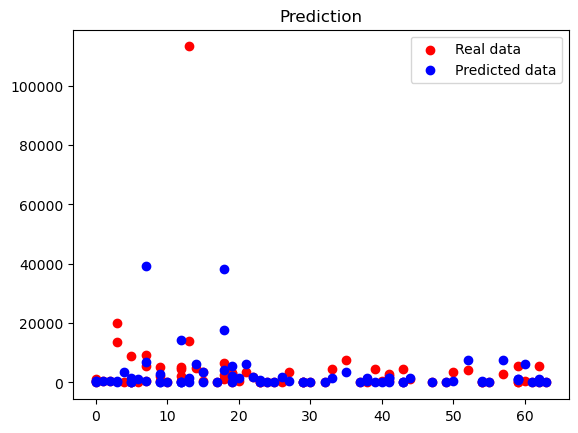

In [18]:
Y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2, suppress=True)
print(np.concatenate((Y_pred.reshape(len(Y_pred), 1), Y_test.reshape(len(Y_test), 1)), 1))

# plot the results
plt.figure()
plt.scatter(X_test[:, 0], Y_test, color='red', label='Real data')
plt.scatter(X_test[:, 0], Y_pred, color='blue', label='Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import r2_score
r2_score(Y_test, Y_pred)

-0.29416989943797445

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100


mean_absolute_percentage_error(Y_test, Y_pred)

1261.163271007063

### Test 